In [10]:
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from pathlib import Path
from typing import List
import numpy as np
import os
import cv2
import re
import imutils
%matplotlib inline
from matplotlib import pyplot as plt
import pytesseract

from alice.config import PROCESSING_INPUT_DIR, logger
from alice.predict import predict_masks
from alice.visualise import visualise_mask
from alice.utils import *
from collections import OrderedDict
from itertools import zip_longest
from imutils import perspective
from typing import List
from operator import attrgetter

import cv2
import numpy as np
from pathlib import Path
from typing import List
import numpy as np
import os
import cv2
import re
import imutils
import pandas as pd
import csv
%matplotlib inline
from matplotlib import pyplot as plt

In [73]:
# paths = [PROCESSING_INPUT_DIR / f'011245996_additional_{i}.jpeg' for i in range(1,5)]
paths = [PROCESSING_INPUT_DIR / f'Tri434014_additional_{i}.JPG' for i in range(1,5)]

In [88]:
class QuadrilateralROI:
    def __init__(self, vertices, is_approx=False):
        # Closest point to the bottom of the canvas
        self.closest_point = self.get_closest_point(vertices)
        
        # Vertices are assigned to a,b,c,d
        # A will be the closest point (with the maximum y value), with the points
        # ordered counter clockwise, with b being the next corner counter clockwise
        # A & C will be opposite each other; B & D opposite
        self.vertices = OrderedDict(zip(['a', 'b', 'c', 'd'], iter_list_from_value(vertices, self.closest_point)))
        
        # Loop through vertices, creating edges names a_b, b_c etc.,
        self.edges = OrderedDict([(
            f'{k1}_{k2}', LineString([
                self.vertices[k1], 
                self.vertices[k2]
            ])) for k1, k2 in pairwise(list(self.vertices.keys()))
        ])
        self.angles = self.get_corner_angles()

    @staticmethod
    def get_closest_point(vertices):
        """
        Get point with lowest y value
        """
        vertices = np.array(vertices)
        return tuple(vertices[np.argmax(vertices[:, 1])])        

    def get_corner_angles(self):
        angles = {}
        for e1, e2 in pairwise(list(self.edges.keys())):
            # The corner will be duplicated by the edge names: tl_tr, tr_br => tr
            vertice = Counter(e1.split('_') + e2.split('_')).most_common(1)[0][0]
            angles[vertice] = calculate_angle_between_lines(self.edges[e1], self.edges[e2])  
        return angles

    def is_wellformed_label_shape(self):
        """
        Validate the label shape, 4 corners & opposite angles be within 15 degrees
        """
        valid_angle = 15
        if len(self.vertices) != 4:
            return False
        oppos_corners = [('a', 'c'), ('b', 'd')]
        max_angle_diff = max([abs(self.angles[i] - self.angles[j]) for i,j in oppos_corners])  
        return max_angle_diff < valid_angle

    def visualise(self, image):
        for edge in self.edges.values():
            p = np.array(edge.coords).astype(np.int32)
            cv2.line(image, p[0], p[1], (0, 255, 0), 5)
        for point in self.vertices.values():
            pt = np.array(point).astype(np.int32)
            cv2.circle(image, pt, 5, (255,0,0), 5)
        return image

    @property
    def x_length(self):
        return round(max([self.edges['a_b'].length, self.edges['c_d'].length]))

    @property
    def y_length(self):
        return round(max([self.edges['b_c'].length, self.edges['d_a'].length]))

    def is_landscape(self):
        return self.x_length > self.y_length

    def get_normalised_label(self, image, max_longest_edge, max_shortest_edge):
    
        if self.is_landscape():
            x = max_longest_edge
            y = max_shortest_edge
        else:
            x = max_shortest_edge
            y = max_longest_edge
            
        dest = np.float32([
            (0, x), #A
            (0, 0), #B
            (y, 0), #C
            (y, x) #D
        ])
        
        src = np.float32(list(self.vertices.values()))
        M = cv2.getPerspectiveTransform(src, dest)
    
        warped_image = cv2.warpPerspective(image, M,(y, x),flags=cv2.INTER_LINEAR) 

        # Longest edge should be the bottom
        h, w = warped_image.shape[:2]
        if h > w:
            warped_image = imutils.rotate_bound(warped_image, -90)

        return warped_image      
            

class LabelMask():
    def __init__(self, data: np.array):
        self._data = data

    @property
    def height(self):
        return self._data.shape[0]

    @property
    def width(self):
        return self._data.shape[1]  

    @property
    def y_midpoint(self):
        """
        Vertical midpoint of a mask
        """        
        return sum([min(np.where(self._data == True)[0]), max(np.where(self._data == True)[0])]) / 2 
        
    def contour(self, epsilon=5):
        contours, _ = cv2.findContours(self._data.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Simplify contour - otherwise approx_best_fit_ngon takes many seconds
        # Requires low epsilon < 10 otherwise approx vertices are out
        if epsilon:
            contours = cv2.approxPolyDP(contours[0], epsilon, True)        
        return contours

    def edges(self) -> np.array:
        """
        Get edges of a mask
        """
        # Diff will reduce width by 1, so prepend with extra column of 0s
        return np.diff(self._data, prepend=np.zeros(self.height)[0])  

    def edge_points(self) -> List:   
        """
        Get the edges 
        """    
        # Find the indices of True values in the mask, and return row col (points)
        return [(col, row) for row, col in np.argwhere(self.edges())]  

    def to_quadrilateral_roi(self):
        """
        Get quadrilateral ROI around mask
        """
        vertices = approx_best_fit_ngon(self.contour())
        quad_roi = QuadrilateralROI(vertices)
        if quad_roi.is_wellformed_label_shape():        
            return quad_roi
        
        # TODO: Log
        # We want to get the two edges intersection at point A (closest corner)
        closest_edges = [quad_roi.edges[e] for e in ['a_b', 'd_a']]
        vertices = approx_quadrilateral_from_closest_edges(closest_edges, self)
        approx_quad_roi = QuadrilateralROI(vertices, is_approx=True)
        if approx_quad_roi.is_wellformed_label_shape():
            return approx_quad_roi  

        # TODO: Log 

class AngledView():

    """
    A view of the specimen 
    """

    min_mask_size = 1500
    
    def __init__(self, path: Path):
        # FIXME: Reading image twice
        self.image = cv2.imread(str(path))
        self.predictions = predict_masks(path)
        self.label_masks = self.label_masks_from_predictions()
        self.rois = self.label_masks_to_rois()

    def label_masks_from_predictions(self):
        label_masks = self.predictions.get('instances').to("cpu").pred_masks.numpy()
        label_masks = self.filter_small_masks(label_masks)
        label_masks = self.remove_overlaps(label_masks)
        label_masks = [LabelMask(m) for m in label_masks]
        # Sort by mask y midpoint
        label_masks.sort(key = attrgetter('y_midpoint'))
        return label_masks

    def label_masks_to_rois(self):
        return [m.to_quadrilateral_roi() for m in self.label_masks]
        
    def filter_small_masks(self, label_masks: np.array):
        return [m for m in label_masks if np.count_nonzero(m) > self.min_mask_size]

    def remove_overlaps(self, label_masks: np.array):
        # FIXME: Doesn't work in Ariana's code
        return label_masks

    def __len__(self):
        return len(self.label_masks)

class Specimen():
    def __init__(self, paths: List[Path]):
        views = [AngledView(p) for p in paths]

        # We only want to use a view if it has the same count as other views
        # So calculate the mean, and any view not equalling mean will be excluded
        num_views_mean = np.mean([len(view) for view in views])
        self.views = [view for view in views if len(view) == num_views_mean]

        if len(self.views) != len(views):
            logger.warning('Mismatched label count between views - %s views will be used', len(self.views))        

    def __iter__(self):
        for view in self.views:
            yield view

    def __len__(self):
        return len(self.views)

    def __getitem__(self, i):
        return self.views[i]

    def get_labels(self, label_index):

        # Normalise labels so they are all equal width and height - using the maximum width/height
        # of the largest label
        dimensions = np.array([
            sorted([view.rois[label_index].x_length, view.rois[label_index].y_length]) for view in self.views
        ])

        max_shortest_edge = np.max(dimensions[:,0])
        max_longest_edge = np.max(dimensions[:,1])    

        labels = []
        for view in self.views:
            roi = view.rois[label_index]
            labels.append(
                roi.get_normalised_label(view.image, max_longest_edge, max_shortest_edge)
            )
        # First two labels will be opposite way up to last two - rotate the last two 180 degrees
        # FIXME: This doesn't check the orientation - but this should work either way
        # labels = labels[:2] + [imutils.rotate_bound(label, 180) for label in labels[2:]]
        return labels
      

specimen = Specimen(paths)

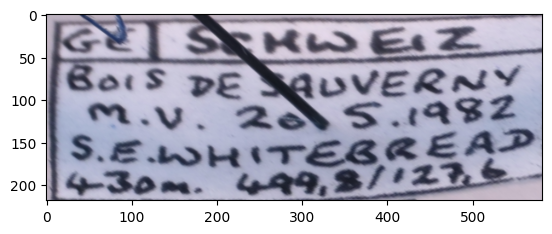

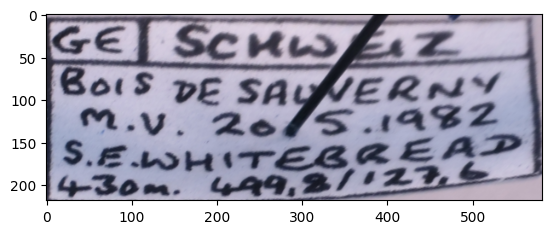

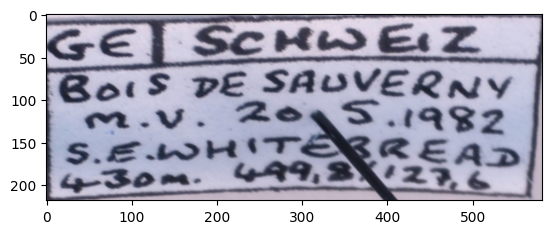

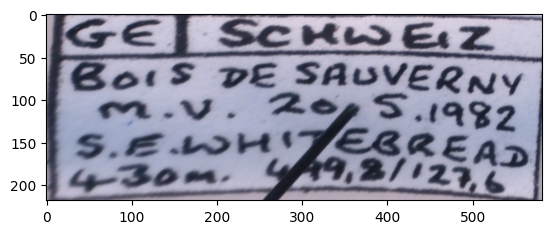

In [92]:
label_index = 0

def get_label_rois(label_index):  
    return [view.rois[label_index] for view in specimen.views]

# for label in specimen.get_labels(label_index):
#     plt.imshow(label), plt.show()

labels = specimen.get_labels(label_index)

labels = labels[:2] + [imutils.rotate_bound(label, 180) for label in labels[2:]]

for label in labels:
    plt.imshow(label), plt.show()
 
#     image = get_perspective_transformed(roi, view.image)
#     plt.imshow(image), plt.show()
    

# def get_normalised_labels(label_index):  
#     rois = get_label_rois(label_index)    

#     for roi in rois:
#         get_perspective_transformed()
        
    
    

In [93]:
for i, img in enumerate(labels):
    # print(img.shape)
    cv2.imwrite(f'ri434014-{i}.jpg', img)


    